Notebook to debug the MCS + NLLS approach.

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt

In [2]:
import os
import sys
from pathlib import Path

In [3]:
src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [4]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune
import pmcx
import scipy

import matplotlib.pyplot as plt

In [5]:
config.data_dir

PosixPath('/home/leon_ivan/data')

In [5]:
config.spectra_dir

PosixPath('/home/leon_ivan/nonlinear-fit/dataset/UCL-NIR-Spectra/spectra')

In [6]:
config.gpuid

4

In [7]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    wavelength_left_cut=520,
    wavelength_right_cut=850,
    num_wavelengths=20
)

delta_A_gt_img = loader.get_attenuation_change("020-01")
A_gt_img = loader.get_attenuation("020-01")

mu_a_matrix_old = loader.absorption_coefs_old(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

mu_a_matrix_static = data_loader.DataLoader.absorption_coefs(
    loader.wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

print(np.allclose(mu_a_matrix, mu_a_matrix_static))
print(np.max(np.abs(mu_a_matrix - mu_a_matrix_static)))

/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


True
0.0


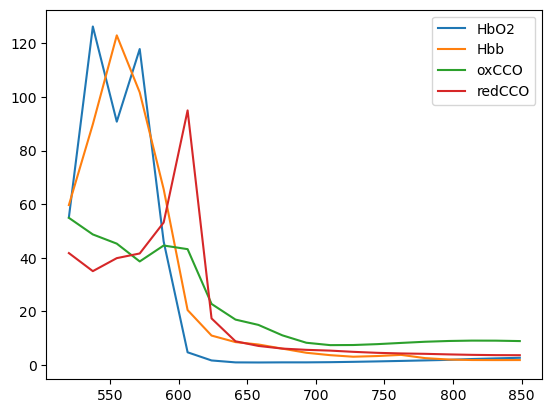

In [8]:
plot_spectra(mu_a_matrix_old[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

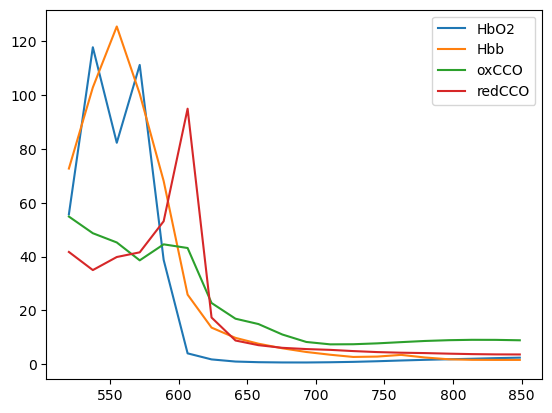

In [9]:
plot_spectra(mu_a_matrix[:, :4].T, loader.wavelengths, ["HbO2", "Hbb", "oxCCO", "redCCO", "Water", "Fat"])

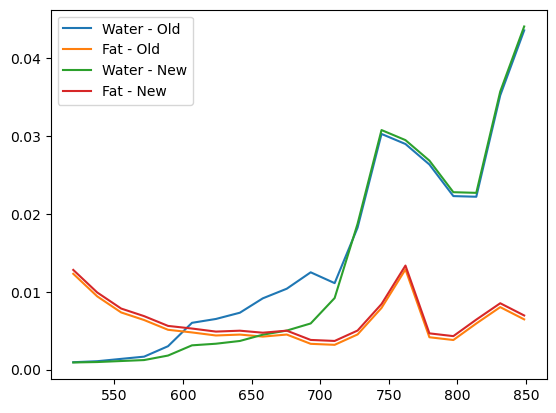

In [10]:
plot_spectra((*(mu_a_matrix_old[:, -2:].T), *(mu_a_matrix[:, -2:].T + 0.0005)), loader.wavelengths, ["Water - Old", "Fat - Old", "Water - New", "Fat - New"])

In [11]:
mu_a_matrix_old[:, -2] / mu_a_matrix[:, -2]

array([2.3025851 , 2.30126438, 2.30221382, 2.30437163, 2.30937602,
       2.29913441, 2.30553602, 2.30155176, 2.29933248, 2.30436851,
       2.30360355, 1.27811221, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [12]:
loader.wavelengths

array([520.        , 537.45454545, 554.90909091, 571.63636364,
       589.09090909, 606.54545455, 624.        , 641.45454545,
       658.18181818, 675.63636364, 693.09090909, 710.54545455,
       727.27272727, 744.72727273, 762.18181818, 779.63636364,
       797.09090909, 813.81818182, 831.27272727, 848.72727273])

In [13]:
mcs_obj1 = SimulationAttenuation(config.mcs_func_path.parent / "function_data1.npz")
mcs_obj2 = SimulationAttenuation(config.mcs_func_path.parent / "function_data2.npz")

Loaded data with 500000.0 photons and 30 values for mu_s.
Loaded data with 500000.0 photons and 30 values for mu_s.


Create spectrum with MCS and compare to MCS-func

In [14]:
g_combined = 0.8675
refractive_index_combined = 1.38
vol = np.ones((50, 50, 500))
prop = np.array([[0, 0, 1, 1], [0, 0, g_combined, refractive_index_combined]])
unitinmm = 1

cfg = {
    "nphoton": 5e6, # keep nphotons relatively low, to limit memory of stored data
    "maxdetphoton": 5e6,
    "unitinmm": unitinmm,
    "vol": vol,
    "tstart":0,
    "tend":1e-8,
    "tstep":1e-8,
    "autopilot": 1,
    "gpuid": config.gpuid,
    "prop":prop,
    "bc": "ccrcca001000", # mark z=0 plane as detector
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [vol.shape[0], 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, vol.shape[1], 0, 0],
    "issrcfrom0": 1,
    "savedetflag": "dps", # detector id, path length, scatter count
    "flog": config.mcs_func_path / "log.txt",
}

In [15]:
mu_a_vals = loader.mu_a_func_gray_matter(loader.wavelengths)
mu_s_vals = loader.mu_s_red_func_gray_matter(loader.wavelengths) / (1-g_combined)

In [69]:
with open(config.result_dir / "A_mcs_generated", "rb") as f:
    A_mcs_generated = pickle.load(f)

In [16]:
A_mcs_generated = np.empty((loader.wavelengths.shape[0],))

for i, wl in enumerate(loader.wavelengths):
    cfg["prop"][1, 0] = mu_a_vals[i] / 10
    cfg["prop"][1, 1] = mu_s_vals[i] / 10
    cfg["prop"][1, 2] = g_combined
    cfg["prop"][1, 3] = refractive_index_combined
    print(f"Iteration {i}/{loader.wavelengths.shape[0]}")
    res = pmcx.mcxlab(cfg)
    weights = pmcx.utils.detweight(res["detp"])
    attenuation = -np.log(np.sum(weights)/cfg["nphoton"])
    A_mcs_generated[i] = attenuation

Iteration 0/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 1/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 2/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 3/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 4/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 5/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 6/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 7/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 8/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 9/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 10/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 11/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 12/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 13/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 14/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 15/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 16/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 17/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 18/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

Iteration 19/20
nphoton: 5e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 5e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1


###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2025 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.io                  #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for research, #
# MCX proudly developed human-readable JSON-based data formats for easy reuse.#
#                                       

In [67]:
print(config.result_dir)

/home/leon_ivan/data/results


In [68]:
with open(config.result_dir / "A_mcs_generated", "wb") as f:
    pickle.dump(A_mcs_generated, f)

In [18]:
A_mcs_func_computed1 = mcs_obj1.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

A_mcs_func_computed2 = mcs_obj2.A_concentrations(
    loader.wavelengths, 
    mu_a_matrix, 
    loader.params_ref_gray_matter[:6],
    *loader.params_ref_gray_matter[-2:]
)

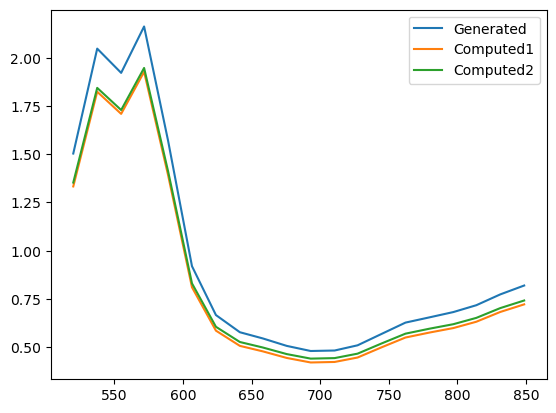

In [19]:
plot_spectra(
    (A_mcs_generated, A_mcs_func_computed1, A_mcs_func_computed2 + 0.02),
    loader.wavelengths,
    labels=["Generated", "Computed1", "Computed2"]
)

In [20]:
A_mcs_generated / A_mcs_func_computed1[:, 0]

array([1.12782599, 1.12252739, 1.12434349, 1.1219275 , 1.1281184 ,
       1.13474267, 1.13795723, 1.13936249, 1.13997533, 1.14054967,
       1.14128323, 1.14007075, 1.14153342, 1.13906624, 1.14048095,
       1.13669651, 1.13831587, 1.13547552, 1.13331618, 1.13520514])

Test fitting with single-thread and without jacobian. See if fitting procedure converges to reference gray matter concentrations, when initialized with slightly perturbed reference concentrations.

In [21]:
init_vals = loader.params_ref_gray_matter + np.array([0.00005, 0.000025, 0.000005, 0.0000025, 0.0005, 0.0015, 0.05, 0.005])
print(init_vals)

[6.4650e-02 1.1425e-02 6.4050e-03 1.6025e-03 7.3050e-01 1.0150e-01
 4.0850e+01 3.0940e+00]


In [22]:
concentrations_to_blood_fraction(init_vals)

array([3.27122500e-02, 8.49819257e-01, 6.40500000e-03, 1.60250000e-03,
       7.30500000e-01, 1.01500000e-01, 4.08500000e+01, 3.09400000e+00])

In [23]:
loader.params_ref_gray_matter_fraction

array([3.268e-02, 8.500e-01, 6.400e-03, 1.600e-03, 7.300e-01, 1.000e-01,
       4.080e+01, 3.089e+00])

In [24]:
%%time 

params_mcs_flat, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    ref_vals=concentrations_to_blood_fraction(init_vals),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)

CPU times: user 15.8 s, sys: 56.6 s, total: 1min 12s
Wall time: 1min 12s


In [27]:
print(params_mcs_flat)

[[4.10846397e-02]
 [8.48042665e-01]
 [7.86767663e-03]
 [2.02873280e-03]
 [9.09410715e-01]
 [1.39804240e-01]
 [3.86945174e+01]
 [3.09002227e+00]]


In [28]:
A_init_reconstr = mcs_obj1.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    init_vals[:6],
    *init_vals[-2:]
)

A_reconstr = mcs_obj1.A_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0]
)

with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

A_jacques_reconstr_combinedm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.38]
)

A_jacques_reconstr_gmm = A_jacques_blood_fraction(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat[:6, 0],
    *params_mcs_flat[-2:, 0],
    *m_params[1.36]
)

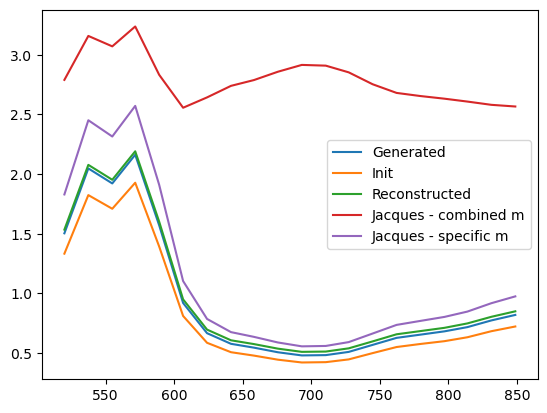

In [29]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.03, A_jacques_reconstr_combinedm, A_jacques_reconstr_gmm), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Jacques - combined m", "Jacques - specific m"])

Result: MCS-Func adjusts values so that reconstructed spectrum is essentially identical to input spectrum. If we fit using concentrations, the values are quite different to reference values. Values are much closer to reference/GT concentrations when blood-fraction-model is used. Jacques only produces similar spectrum, if m-parameters for correct tissue type are used.

Compute the jacobian using automatic differentiation, and compute to analytic Jacobian.

In [44]:
def f(x):
    m, batch = x.shape[0], x.shape[1:]  # x.shape is (m, ...)
    x = np.reshape(x, (m, -1))  # `-1` is short for q = prod(batch)
    res = mcs_obj1.A_concentrations(loader.wavelengths, mu_a_matrix, x[:6, :], *x[-2:, :])  # pass shape (m, q) to function
    n = res.shape[0]
    return np.reshape(res, (n,) + batch)  # return shape (n, ...)

In [45]:
test_vals = loader.params_ref_gray_matter
print(test_vals)

[6.460e-02 1.140e-02 6.400e-03 1.600e-03 7.300e-01 1.000e-01 4.080e+01
 3.089e+00]


In [46]:
%%time
res = scipy.differentiate.jacobian(f, test_vals)

/home/leon_ivan/nonlinear-fit/src/mcs_function.py:27: RuntimeWarning: overflow encountered in exp
  return np.exp(-mu_a[..., None] * self.photon_data[mu_s_idx, 0, :])
/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/leon_ivan/miniconda3/envs/nonlinear-fit/lib/python3.11/site-packages/scipy/differentiate/_differentiate.py:537: RuntimeWarning: invalid value encountered in matmul
  work.df[ic] = fc @ wc / work.h[ic]


In [48]:
ref = mcs_obj1.jacobian_concentrations(loader.wavelengths, mu_a_matrix, test_vals[:6], *test_vals[-2:])

In [53]:
ref.dtype

dtype('float64')

In [52]:
res.df.dtype

dtype('float64')

In [56]:
res.df

array([[            nan,             nan,             nan,
                    nan,  4.87684241e-05,  1.46782225e-03,
        -1.42537484e-02,  2.28089208e-02],
       [            nan,             nan,             nan,
                    nan,  3.85370881e-05,  7.79075662e-04,
        -1.87987281e-02,  5.54042229e-02],
       [            nan,             nan,             nan,
                    nan,  6.01868145e-05,  7.41426645e-04,
        -1.84000741e-02,  7.82224877e-02],
       [            nan,             nan,             nan,
                    nan,  6.59830573e-05,  5.84156209e-04,
        -1.88130901e-02,  1.02774303e-01],
       [            nan,             nan,             nan,
                    nan,  2.13678692e-04,  8.40374247e-04,
        -1.53607229e-02,  1.02764383e-01],
       [            nan,             nan,             nan,
                    nan,  9.77616647e-04,  1.78560580e-03,
        -9.17235072e-03,  7.22909666e-02],
       [            nan,          

In [62]:
dx = 1e8
input_vals = loader.params_ref_gray_matter
x = np.tile(input_vals[:, None], (1, 8))
x_dx = x + dx * np.eye(8)
jac = mcs_obj1.A_concentrations(loader.wavelengths, mu_a_matrix, x[:-2, :], *x[-2:, :]) - mcs_obj1.A_concentrations(loader.wavelengths, mu_a_matrix, x_dx[:-2,:], *x[-2:, :])
jac /= dx

In [63]:
jac.shape

(20, 8)

In [66]:
jac

array([[           -inf,            -inf,            -inf,
                   -inf, -9.24932862e-08, -1.24862970e-07,
         0.00000000e+00,  0.00000000e+00],
       [           -inf,            -inf,            -inf,
                   -inf, -9.02247608e-08, -1.18027253e-07,
         0.00000000e+00,  0.00000000e+00],
       [           -inf,            -inf,            -inf,
                   -inf, -9.45759026e-08, -1.17150813e-07,
         0.00000000e+00,  0.00000000e+00],
       [           -inf,            -inf,            -inf,
                   -inf, -9.43224544e-08, -1.14328664e-07,
         0.00000000e+00,  0.00000000e+00],
       [           -inf,            -inf,            -inf,
                   -inf, -1.04944622e-07, -1.18099066e-07,
         0.00000000e+00,  0.00000000e+00],
       [-6.06104865e-06,            -inf,            -inf,
                   -inf, -1.17204446e-07, -1.23864905e-07,
         0.00000000e+00,  0.00000000e+00],
       [-2.99248296e-06,          

Test if using the jacobian works and produces the same results.

In [64]:
%%time

params_mcs_flat_jacobian, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_concentrations,
    jacobian=mcs_obj1.jacobian_concentrations,
    ref_vals=init_vals,
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 1, 1, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)

CPU times: user 2.03 s, sys: 611 ms, total: 2.64 s
Wall time: 2.65 s


In [65]:
A_reconstr_jacobian = mcs_obj1.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    params_mcs_flat_jacobian[:6, 0],
    *params_mcs_flat_jacobian[-2:, 0]
)

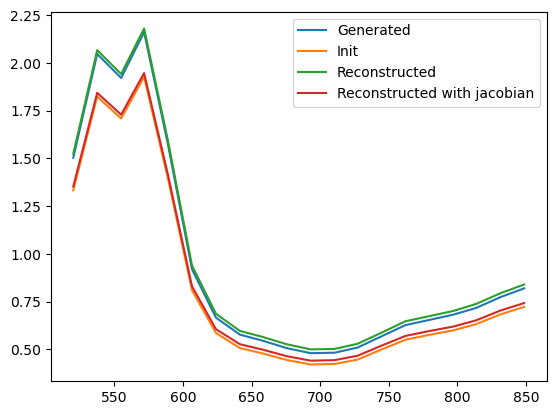

In [66]:
plot_spectra((A_mcs_generated, A_init_reconstr, A_reconstr + 0.02, A_reconstr_jacobian + 0.02), loader.wavelengths, ["Generated", "Init", "Reconstructed", "Reconstructed with jacobian"])

Testing for real spectra.

In [ ]:
test_mask = np.zeros_like(loader.label_map)
test_mask[np.unravel_index(np.random.choice(np.flatnonzero(loader.label_map == 1), size=3, replace=True), labeled_mask.shape)] = True
print(test_mask.shape)

In [ ]:
params_mcs_flat, errors = concentr_fit_nonlinear(
    A_mcs_generated[:, None],
    loader.wavelengths,
    mu_a_matrix,
    mcs_obj1.A_blood_fraction,
    ref_vals=concentrations_to_blood_fraction(init_vals),
    variables_bool_arr=np.array([True, True, True, True, True, True, True, True]),
    left_bounds=np.array([0, 0, 0, 0, 0, 0, 3, 0.1]),
    right_bounds=np.array([1, 1, 0.01, 0.01, 1, 1, 100, 10]),
    is_delta_A=False,
    progress_bar=False,
)